# Self-Driving Car Engineer Nanodegree

## Advanced Lane Line Finding Project !

This project is about finding lane lines on the road. It is called "Advanced Lane Line finding" because there is already a first version of a lane finder algorithm in https://github.com/Jeremy26/lane-lines

Today, we are using more sophisticated and fitted computer vision techniques to find lane lines on the road and evaluate the position of a car in a lane.

The steps will be the following : 
* Read images
* Process on Camera Calibration with a chessboard picture
* Correct image distortion
* Apply Color & Gradient Threshold in order to find the lanes
* Apply Perspective transform to have a bird's eye view of the road and not a perspective view
* Finally, we need to decide which pixels will be lane lines, we will work on curvatures, radius, and many more

## Read images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

## Process on Camera Calibration with a Chessboard Picture

### We first define object points and image points and draw chessboard Corners to check on Calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images using the Glob API
calibration_images = glob.glob('camera_cal/calibration*.jpg')
test_images = glob.glob('test_images/*.jpg')

In [3]:
def get_points():
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(calibration_images):
        image = mpimg.imread(fname)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(image, (9,6), corners, ret)
            #write_name = 'corners_found'+str(idx)+'.jpg'
            #cv2.imwrite(write_name, img)
            #cv2.imshow('img', image)
            if (idx==1):
                plt.imshow(image)
                plt.show()
            cv2.waitKey(500)
    return objpoints, imgpoints

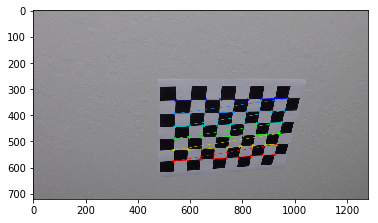

An example of an object point (top-left corner) and its corresponding image point
[ 0.  0.  0.]
[[ 545.32281494  343.05032349]]


In [4]:
## An example of object points and image points
objpoints, imgpoints = get_points()
print("An example of an object point (top-left corner) and its corresponding image point")
print(objpoints[0][0])
print(imgpoints[0][0])
cv2.destroyAllWindows()

#### Then, we are ready to do the camera calibration and undistortion and display one example

In [5]:
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

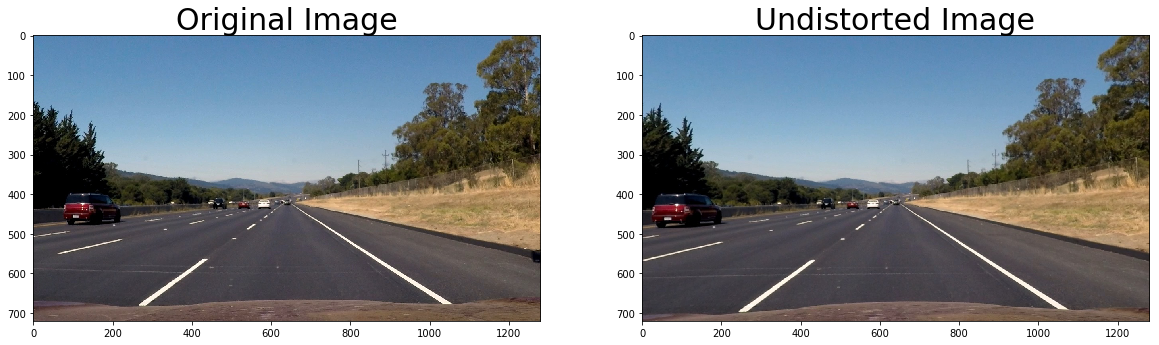

In [7]:
for idx, fname in enumerate (test_images):
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    # Test on one image
    if (idx==1):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=30)

## Apply Color & Gradient Thresholding in order to find the lanes

### We will take care of gradient first

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return grad_binary

In [9]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

In [10]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

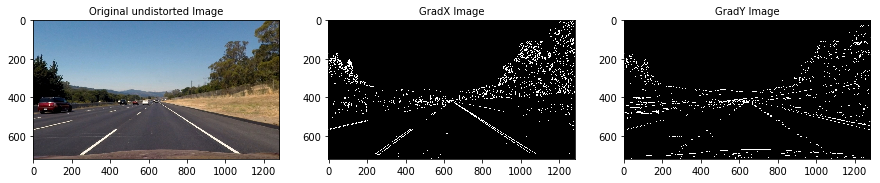

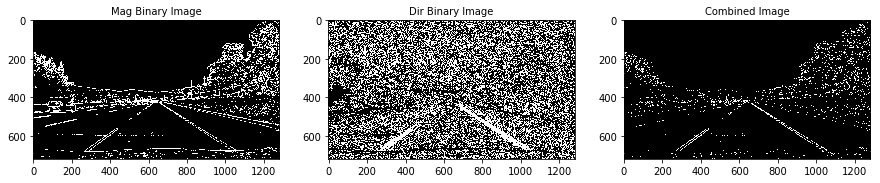

In [11]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        
        # Combine Gradients
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1)&(grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        
        #Plot the results
        f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(gradx, cmap='gray')
        ax1.set_title('GradX Image', fontsize=10)
        ax2.imshow(grady, cmap='gray')
        ax2.set_title('GradY Image', fontsize =10)
        
        f, (ax3,ax4,ax5) = plt.subplots(1,3, figsize =(15,10))
        ax3.imshow(mag_binary, cmap='gray')
        ax3.set_title('Mag Binary Image', fontsize =10)
        ax4.imshow(dir_binary, cmap='gray')
        ax4.set_title('Dir Binary Image', fontsize =10)
        ax5.imshow(combined, cmap='gray')
        ax5.set_title('Combined Image', fontsize =10)

### Now for Color

In [12]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1    
    return binary_output

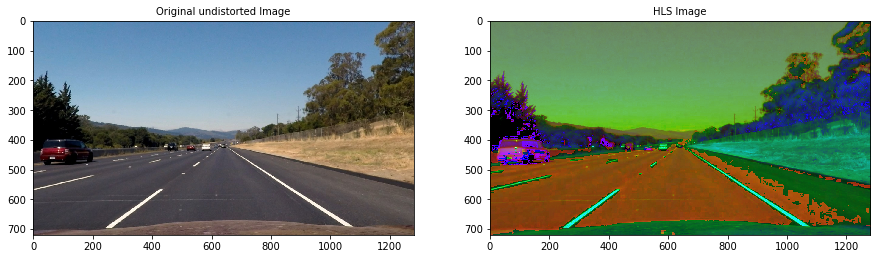

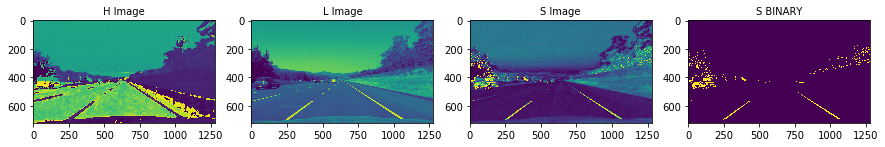

In [14]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        s_binary = hls_select(undistorted, thresh = (170,255))
        
        #Plot the results
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(hls)
        ax1.set_title('HLS Image', fontsize=10)
        f, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4, figsize=(15,10))
        ax2.imshow(H)
        ax2.set_title('H Image', fontsize =10)
        ax3.imshow(L)
        ax3.set_title('L Image', fontsize =10)
        ax4.imshow(S)
        ax4.set_title('S Image', fontsize =10)
        ax5.imshow(s_binary)
        ax5.set_title('S BINARY', fontsize =10)

### Combining the 2

In [15]:
def combined_color_gradient(color, gradient):
    binary = np.dstack(( np.zeros_like(gradient), gradient, color))
    # Combine the two binary thresholds
    combined = np.zeros_like(gradient)
    combined[(color == 1) | (gradient == 1)] = 1
    return combined

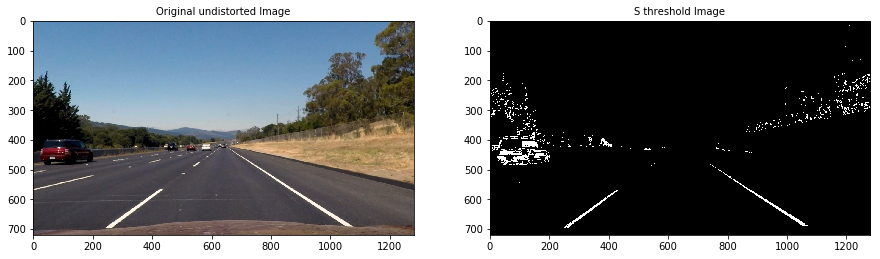

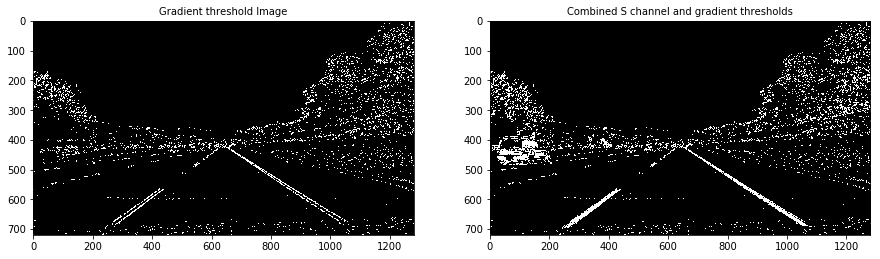

In [16]:
for idx, fname in enumerate (test_images):
    # Test on one image
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        ## COLOR
        s_binary = hls_select(undistorted, thresh = (170,255))
        ## GRADIENT
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        combined_gradient = np.zeros_like(dir_binary)
        combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

        ## COLOR AND GRADIENT
        ccg = combined_color_gradient(s_binary,combined_gradient)
        
        #Plot the results
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
        ax0.imshow(undistorted)
        ax0.set_title('Original undistorted Image', fontsize=10)
        ax1.imshow(s_binary, cmap='gray')
        ax1.set_title('S threshold Image', fontsize=10)
        f, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,10))
        ax2.imshow(combined_gradient, cmap = 'gray')
        ax2.set_title('Gradient threshold Image', fontsize =10)
        ax3.imshow(ccg, cmap='gray')
        ax3.set_title('Combined S channel and gradient thresholds', fontsize =10)

## Apply perspective Transform

In [17]:
def perspective_transform(img):
    ## The given image is already undistorted
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[575,450],[700,450],[1200,720],[0,720]])
    dst = np.float32([[350, 0], [950, 0],[950, 720],[350,720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

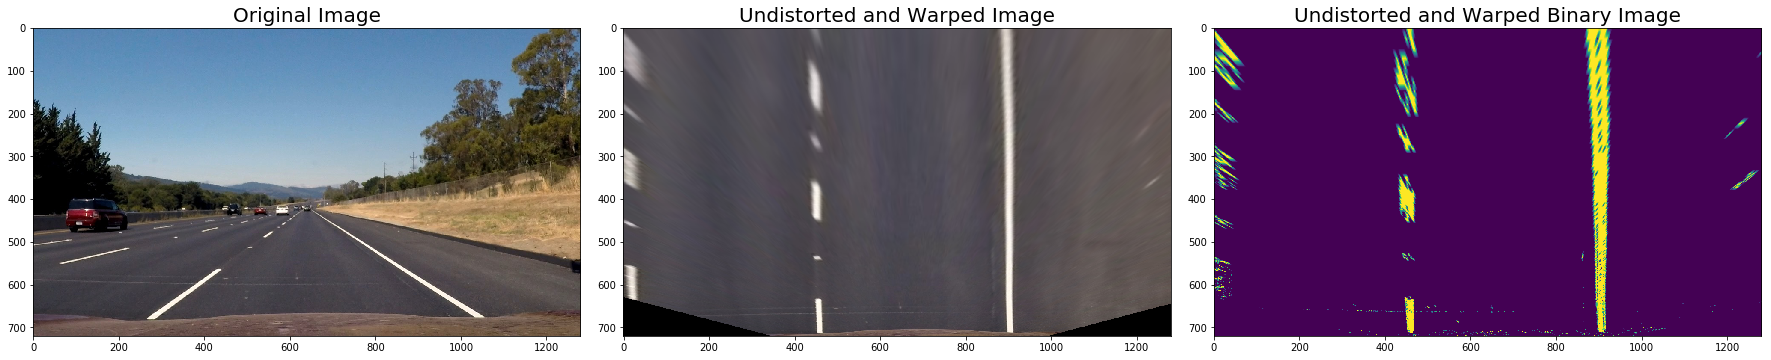

In [18]:
for idx, fname in enumerate (test_images):
    if (idx==1):
        img = mpimg.imread(fname)
        undistorted = cal_undistort(img, objpoints, imgpoints)
        ## COLOR
        s_binary = hls_select(undistorted, thresh = (170,255))
        ## GRADIENT
        gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
        grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
        mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
        dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
        combined_gradient = np.zeros_like(dir_binary)
        combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        ## COLOR AND GRADIENT
        ccg = combined_color_gradient(s_binary,combined_gradient)    

        ## PERSPECTIVE TRANSFORMED
        birded, M = perspective_transform(undistorted)
        top_down, perspective_M = perspective_transform(ccg)

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(birded)
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        ax3.imshow(top_down)
        ax3.set_title('Undistorted and Warped Binary Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## At this point, we need to identify the right lanes from the left lanes

### Sliding Window using the histogram Peaks

In [25]:
def sliding_window(top_down):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((top_down, top_down, top_down))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(top_down.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = top_down.shape[0] - (window+1)*window_height
        win_y_high = top_down.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((top_down, top_down, top_down))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #FOR REPORT ONLY, PLOT THE DATA
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return left_fit, right_fit

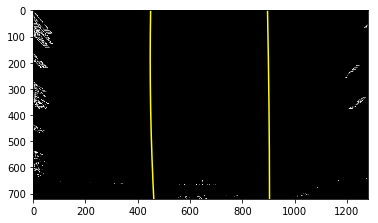

In [26]:
left_fit, right_fit = sliding_window(top_down)

In [21]:
def new_sliding(top_down,left_fit, right_fit):
# Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = top_down.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((top_down, top_down, top_down))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #FOR REPORT ONLY, PLOT THE DATA
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return result, leftx, rightx,lefty,righty,left_fitx,right_fitx, left_fit, right_fit,ploty 

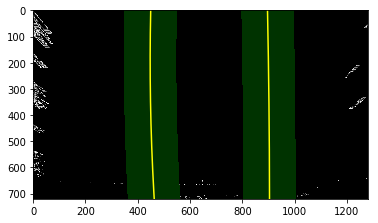

In [22]:
result,leftx,rightx,lefty,righty,left_fitx, right_fitx,left_fit,right_fit,ploty = new_sliding(top_down,left_fit, right_fit)

## Now, we measure the radius of curvature

In [27]:
def curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty):  
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
   # print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
   # print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

2931.1385338
12106.9623489
7519.05044135


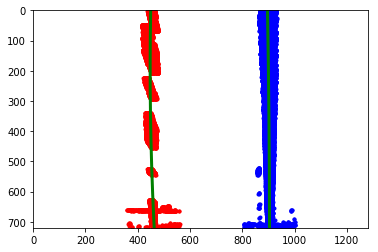

In [28]:
    ##PLOTING FOR REPORT ONLY
    mark_size = 3
    plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images

left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
curve = (left_curverad+right_curverad)/2.0
print(left_curverad)
print(right_curverad)
print(curve)

### Determine the position to the center of the lane

In [29]:
def position_to_center(left_fitx, right_fitx,result):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2.0
    camera_center = result.shape[1]/2.0
    xm_per_pix = 3.7/700
    distance_to_center = (lane_center - camera_center)*xm_per_pix
    return distance_to_center

In [30]:
distance_to_center = position_to_center(left_fitx,right_fitx,result)
print(distance_to_center)

0.229841139436


## Plot the Images

In [31]:
def draw_on_lane(img, undistorted,top_down, perspective_M, left_fitx, right_fitx, ploty, curve, distance):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_M, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(result_img,"Curvature "+str(curve),(400,100), font, 1,(255,255,255),2)
    cv2.putText(result_img,"Distance to Center "+str(distance),(400,150), font, 1,(255,255,255),2)

    return result_img

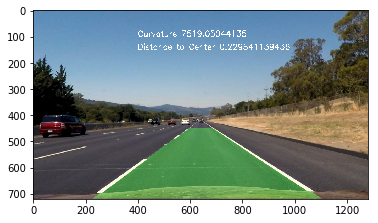

In [32]:
result_img = draw_on_lane(img, undistorted,top_down, np.linalg.inv(perspective_M),left_fitx, right_fitx, ploty,curve,distance_to_center)

plt.imshow(result_img)

## Define Main function

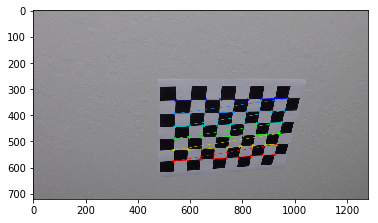

In [18]:
objpoints, imgpoints = get_points()

In [16]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    ## COLOR THRESHOLD
    s_binary = hls_select(undistorted, thresh = (170,255))
    ## GRADIENT THRESHOLD
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh_min =20,thresh_max= 120)
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh_min =30,thresh_max= 80)
    mag_binary = mag_thresh(undistorted, sobel_kernel=9, mag_thresh=(20, 200))
    dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    ## COMBINED COLOR AND GRADIENT
    ccg = combined_color_gradient(s_binary,combined_gradient)    

    ## PERSPECTIVE TRANSFORMED
    top_down, perspective_M = perspective_transform(ccg)

    ## SLIDING WINDOW SEARCH
    left_fit, right_fit = sliding_window(top_down)
    result,leftx,rightx,lefty,righty,left_fitx, right_fitx,left_fit,right_fit,ploty = new_sliding(top_down,left_fit, right_fit)
    
    ## RADIUS OF CURVATURE
    left_curverad, right_curverad = curvature(leftx,rightx,lefty,righty,left_fitx,right_fitx,left_fit, right_fit,ploty)
    curve = (left_curverad + right_curverad)/2.0
    
    ## POSITION TO CENTER
    distance_to_center = position_to_center(left_fitx,right_fitx,result)
    
    ## DRAW ON LANE
    result_img = draw_on_lane(img, undistorted,top_down, np.linalg.inv(perspective_M),left_fitx, right_fitx, ploty,curve,distance_to_center)

    return result_img

## Test on Images

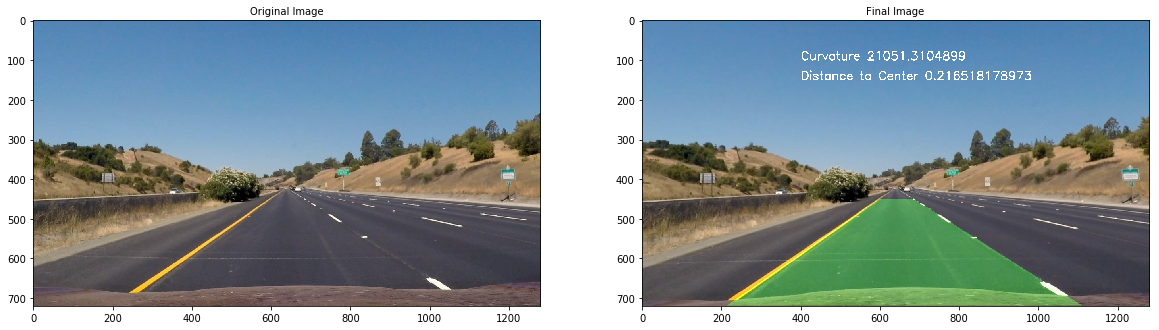

In [32]:
for idx, fname in enumerate (test_images):
    if (idx==0):
        img = mpimg.imread(fname)
        result_img = pipeline(img)
            
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
        ax1.imshow(img)
        ax1.set_title("Original Image", fontsize=10)

        ax2.imshow(result_img)
        ax2.set_title("Final Image", fontsize=10)

## Test on Project Video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [20:04<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 20min 20s, sys: 2min 26s, total: 22min 46s
Wall time: 20min 5s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Test On Challenge Video

In [29]:
challenge_output = 'result_challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


100%|██████████| 485/485 [07:26<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_challenge.mp4 

CPU times: user 7min 38s, sys: 53.5 s, total: 8min 32s
Wall time: 7min 27s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Test on Harder Challenge

In [30]:
harder_challenge_output = 'result_harder_challenge.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video result_harder_challenge.mp4
[MoviePy] Writing video result_harder_challenge.mp4


100%|█████████▉| 1199/1200 [20:37<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_harder_challenge.mp4 

CPU times: user 20min 17s, sys: 2min 32s, total: 22min 49s
Wall time: 20min 39s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))